In [8]:
#Imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [9]:
#Load dataset
df = pd.read_csv('data_ass2_wk4.csv')
df.head()

,CustomerId,ProfitScore,Exited,Age,Cumamountpaidout,Numofinsurances,EstimatedSalary,Geography,Estimationsample
0,15704442,672,1,53,169406.33,4,147311.47,Argentina,1
1,15607993,625,0,52,79468.96,1,84606.03,Argentina,1
2,15635502,443,0,44,0.00,1,159165.70,Argentina,0
3,15631912,840,0,30,136291.71,1,54113.38,Argentina,0
4,15788539,501,0,34,107747.57,1,9249.36,Argentina,0


In [10]:
#Question 1: retention rate
total = 0
total_stayed = 0
for index, i in enumerate(df['Exited']):
  if df['Estimationsample'][index] == 0:
    total += 1
    if i == 0:
      total_stayed += 1

loyalty_rate = total_stayed / total

print(f'Current Loyalty Rate: {loyalty_rate}')

Current Loyalty Rate: 0.7317948717948718


In [11]:
#Question 2: CLV of customers
#Taking only the current customers for calculating equity
M = 10
C = 4
r = loyalty_rate
AC = 15

CLV = ((M - C) / (1 - r)) - AC

customer_equity = CLV * total_stayed

print(f'CLV of a customer = {CLV}')
print(f'Customer equity = {customer_equity}')

CLV of a customer = 7.37093690248566
Customer equity = 21036.653919694072


In [12]:
#Question 3: Manager Scenarios

#Scenario 1:
r_scenario_1 = r + 0.005
C_scenario_1 = 5
CLV_scenario_1 = ((M - C_scenario_1) / (1 - r_scenario_1)) - AC
customer_equity_scenario_1 = CLV_scenario_1 * total_stayed

#Scenario 2:
AC_scenario_2 = 15.5
CLV_scenario_2 = ((M - C) / (1 - r)) - AC_scenario_2
customer_equity_scenario_2 = CLV * (total_stayed * 1.08)

print(f'Current customer equity = {customer_equity}')
print(f'Scenario 1 - customer equity = {customer_equity_scenario_1}')
print(f'Scenario 1 - CLV = {CLV_scenario_1}')
print(f'Scenario 2 - customer equity = {customer_equity_scenario_2}')
print(f'Scenario 2 - CLV = {CLV_scenario_2}')

Current customer equity = 21036.653919694072
Scenario 1 - customer equity = 11406.268874817342
Scenario 1 - CLV = 3.9965903555772044
Scenario 2 - customer equity = 22719.5862332696
Scenario 2 - CLV = 6.87093690248566


Scenario 1 has the highest customer equity, and thus focus on retention

In [13]:
#Question 4: Logistic Regression - retention
estsample = df[df["Estimationsample"]==0]

X_sample = estsample[["ProfitScore", "Age", "Cumamountpaidout", "Numofinsurances", "EstimatedSalary","Geography"]]
X = pd.get_dummies(X_sample,columns=["Geography"],dtype=float).drop(columns="Geography_Argentina")
y = estsample[["Exited"]]

X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.451145
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                 3900
Model:                          Logit   Df Residuals:                     3892
Method:                           MLE   Df Model:                            7
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                  0.2241
Time:                        11:36:51   Log-Likelihood:                -1759.5
converged:                       True   LL-Null:                       -2267.7
Covariance Type:            nonrobust   LLR p-value:                3.285e-215
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.3297      0.398    -15.911      0.000      -7.109      -5.550
ProfitScore

In [14]:
#Question 5: Person 1 or 2 churn
new_data = pd.DataFrame({
    'const': [1, 1],
    'ProfitScore': [580, 850],
    'Age': [25, 54],
    'Cumamountpaidout': [10000, 100000],
    'Numofinsurances': [3, 1],
    'EstimatedSalary': [100000, 50000],
    'Geography_Brazil': [1, 0],
    'Geography_Chile': [0, 1]
})
churn_probabilities = result.predict(new_data)

print(f'Churn probability person 1: {churn_probabilities[0]}')
print(f'Churn probability person 2: {churn_probabilities[1]}')

Churn probability person 1: 0.04755941529030263
Churn probability person 2: 0.7140173945822397


Thus person 2 has the higher chance to churn.

In [15]:
# Question 6: churn probabilities of the customers left
df = df[df["Estimationsample"]==1]

X_sample = estsample[["ProfitScore", "Age", "Cumamountpaidout", "Numofinsurances", "EstimatedSalary","Geography"]]
X = pd.get_dummies(X_sample,columns=["Geography"],dtype=float).drop(columns="Geography_Argentina")
y = estsample[["Exited"]]

df = sm.add_constant(X)

churn_probabilities = result.predict(df)

df['PredictedChurn'] = churn_probabilities
print(churn_probabilities)

2       0.343507
3       0.079004
4       0.137206
6       0.445978
7       0.233369
          ...   
7990    0.141572
7992    0.050587
7995    0.045449
7996    0.432261
7998    0.157259
Length: 3900, dtype: float64


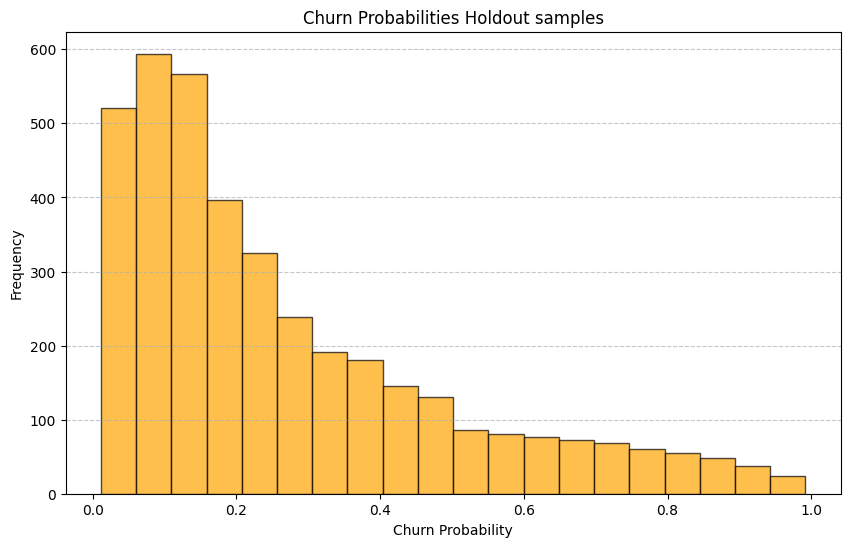

In [16]:
#Plot the churn probabilities
churn_probs = df['PredictedChurn']

plt.figure(figsize=(10, 6))
plt.hist(churn_probs, bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.title('Churn Probabilities Holdout samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
#Question 7: comparing top 10% churn with the rest

df_sorted = df.sort_values('PredictedChurn')

#split into 90%, 10%
split_index = int(len(df_sorted) * 0.9)

df_first_90 = df_sorted.iloc[:split_index]
df_last_10 = df_sorted.iloc[split_index:]

#mean AGE
mean_age_churn = df_last_10['Age'].mean()
mean_age_NOT_churn = df_first_90['Age'].mean()

print(f'Mean age high churn: {mean_age_churn}')
print(f'Mean age lower churn: {mean_age_NOT_churn}\n')

#mean SALARY
mean_salary_churn = df_last_10['EstimatedSalary'].mean()
mean_salary_NOT_churn = df_first_90['EstimatedSalary'].mean()

print(f'Mean salary high churn: {mean_salary_churn}')
print(f'Mean salary lower churn: {mean_salary_NOT_churn}\n')

#mean PRofitscore
mean_profit_churn = df_last_10['ProfitScore'].mean()
mean_profit_NOT_churn = df_first_90['ProfitScore'].mean()

print(f'Mean profitscore high churn: {mean_profit_churn}')
print(f'Mean profitscore lower churn: {mean_profit_NOT_churn}\n')

#mean paidout
mean_paidout_churn = df_last_10['Cumamountpaidout'].mean()
mean_paidout_NOT_churn = df_first_90['Cumamountpaidout'].mean()

print(f'Mean paid out high churn: {mean_paidout_churn}')
print(f'Mean paid out lower churn: {mean_paidout_NOT_churn}\n')

#mean number of insurences
mean_insur_churn = df_last_10['Numofinsurances'].mean()
mean_insur_NOT_churn = df_first_90['Numofinsurances'].mean()

print(f'Mean insurences high churn: {mean_insur_churn}')
print(f'Mean insurences lower churn: {mean_insur_NOT_churn}\n')

Mean age high churn: 55.12307692307692
Mean age lower churn: 36.004273504273506

Mean salary high churn: 102419.90833333334
Mean salary lower churn: 100684.76463532764

Mean profitscore high churn: 638.6128205128205
Mean profitscore lower churn: 647.4726495726495

Mean paid out high churn: 101966.98625641025
Mean paid out lower churn: 73971.8210940171

Mean insurences high churn: 1.3615384615384616
Mean insurences lower churn: 1.541025641025641



The company should thus target older people, with a higher salary